# Valid Trend Lines Detection Without Price Crossing

This notebook implements a simple algorithm to find valid trend lines that are never crossed by price after they're established:

- **Downtrend lines (red)**: Connect significant highs, price never crosses above
- **Uptrend lines (green)**: Connect significant lows, price never crosses below

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Set plotting style
plt.style.use('ggplot')

# Set figure size for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]

# Set y-axis formatter to not use scientific notation
plt.rcParams['axes.formatter.useoffset'] = False

In [137]:
# Load price data
df = pd.read_parquet("../data/dataset.parquet")

# If needed, filter to a specific ticker
# df = df[df['ticker'] == 'AAPL']

# Make sure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data from 2015 onwards
start_date = '2015-01-01'
df = df[df['date'] >= start_date]

# Sort by date
df = df.sort_values('date')

# Reset index for easier indexing
df = df.reset_index(drop=True)

# Display info about the filtered dataset
print(f"Dataset shape after filtering: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Dataset shape after filtering: (2434, 323)
Date range: 2015-01-02 00:00:00 to 2024-09-04 00:00:00


,date,open,high,low,close,adj close,volume,up_down_close_1,volitility_open_7,volitility_pct_change_7_open,...,volume_lag_29,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400,0,0.214018,0.009812,...,167476800.0,4,2,1,2015,1,27.602672,24.658310,2.944362,-0.079103
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,1,0.467657,0.012853,...,173582000.0,0,5,1,2015,2,27.561881,24.677257,2.884624,-0.111073
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689533,263188400,1,0.694560,0.013373,...,228717200.0,1,6,1,2015,2,27.522787,24.696041,2.826747,-0.135160
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021709,160423600,1,0.779355,0.014377,...,189803200.0,2,7,1,2015,2,27.499835,24.718344,2.781491,-0.144332
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944679,237458000,1,0.694844,0.015372,...,275361600.0,3,8,1,2015,2,27.518371,24.750723,2.767647,-0.126541


## 1. Finding Local Extrema (Peaks and Troughs)

# We use signal processing techniques to identify significant high and low points in the price data.

In [138]:
def find_absolute_extreme_sequence(df, mode='lows', n_points=75, min_distance=5):
    """
    Find a sequence of absolute extreme points in order with improved distribution.
    
    Args:
        df: DataFrame with price data
        mode: 'lows' to find lowest points, 'highs' to find highest points
        n_points: Maximum number of points to find
        min_distance: Minimum distance between points in index units
        
    Returns:
        DataFrame with extreme points in absolute order
    """
    if mode == 'lows':
        # Working with low prices
        price_col = 'low'
        sort_ascending = True
    else:
        # Working with high prices
        price_col = 'high'
        sort_ascending = False
    
    # Create a copy for tracking
    data = df[['date', price_col]].copy()
    data['idx'] = data.index
    
    # Sort by the price column to find absolute extremes
    sorted_data = data.sort_values(price_col, ascending=sort_ascending)
    
    # Initialize container for selected points
    selected_points = []
    used_indices = set()
    
    # Select points ensuring minimum distance between them
    for _, row in sorted_data.iterrows():
        idx = row['idx']
        
        # Skip if too close to already selected points
        if any(abs(idx - used_idx) < min_distance for used_idx in used_indices):
            continue
            
        selected_points.append(row)
        used_indices.add(idx)
        
        # Stop once we have enough points
        if len(selected_points) >= n_points:
            break
    
    # Convert to DataFrame and sort by index (chronological order)
    if selected_points:
        result = pd.DataFrame(selected_points).sort_values('idx')
        return result
    else:
        # Return empty DataFrame with same structure if no points found
        return pd.DataFrame(columns=sorted_data.columns)

In [139]:
def find_sequential_trendlines(df, mode='lows', min_distance=5, max_lines=100):
    """
    Create sequential trendlines starting from absolute extrema and connecting to next available
    extrema without price crossing the line.
    
    Args:
        df: DataFrame with price data
        mode: 'lows' for uptrends starting from absolute lowest, 'highs' for downtrends from highest
        min_distance: Minimum distance between points
        max_lines: Maximum number of lines to create
        
    Returns:
        Dictionary with trendlines and termination points
    """
    if mode == 'lows':
        # Working with low prices for uptrends
        price_col = 'low'
        opposite_col = 'high'  # For checking crossovers
        sort_ascending = True
        crossing_condition = lambda price, line_price: price < line_price  # Price below line is a crossover
    else:
        # Working with high prices for downtrends
        price_col = 'high'
        opposite_col = 'low'  # For checking crossovers
        sort_ascending = False
        crossing_condition = lambda price, line_price: price > line_price  # Price above line is a crossover
    
    # Find the absolute extreme starting point
    extreme_idx = df[price_col].idxmin() if mode == 'lows' else df[price_col].idxmax()
    extreme_price = df.loc[extreme_idx, price_col]
    extreme_date = df.loc[extreme_idx, 'date']
    
    # Initialize with the starting point
    current_point = (extreme_idx, extreme_price)
    trendlines = []
    termination_points = []
    
    # Track used points to avoid duplicates
    used_indices = {extreme_idx}
    
    # Continue creating lines until we reach the end
    for _ in range(max_lines):
        # Find the next valid extreme point that doesn't cause a line crossing
        next_point = None
        
        # Sort the remaining data by the price column
        remaining_df = df[(df.index > current_point[0]) & (~df.index.isin(used_indices))].copy()
        remaining_df = remaining_df.sort_values(price_col, ascending=sort_ascending)
        
        # Find the next valid connection
        for idx, row in remaining_df.iterrows():
            # Skip if too close to current point
            if idx - current_point[0] < min_distance:
                continue
                
            candidate_point = (idx, row[price_col])
            
            # Check if connecting to this point would cross price action
            valid_connection = True
            
            # Verify no price crossing by checking each bar between the points
            intermediate_df = df.loc[current_point[0]+1:candidate_point[0]-1]
            for i, bar in intermediate_df.iterrows():
                # Calculate projected price at this index
                projected_price = line_equation(
                    current_point[0], current_point[1],
                    candidate_point[0], candidate_point[1],
                    i
                )
                
                # Check if price crosses the line
                if crossing_condition(bar[opposite_col], projected_price):
                    valid_connection = False
                    break
            
            if valid_connection:
                next_point = candidate_point
                break
        
        # If no valid connection found, mark termination and stop
        if next_point is None:
            termination_points.append({
                'idx': current_point[0],
                'price': current_point[1],
                'date': df.loc[current_point[0], 'date']
            })
            break
        
        # Add the valid trendline
        trendlines.append({
            'point1': current_point,
            'point2': next_point,
            'date1': df.loc[current_point[0], 'date'],
            'date2': df.loc[next_point[0], 'date'],
            'slope': (next_point[1] - current_point[1]) / (next_point[0] - current_point[0])
        })
        
        # Update current point for next iteration
        current_point = next_point
        used_indices.add(next_point[0])
    
    return {
        'trendlines': trendlines,
        'termination_points': termination_points
    }

## 2. Validating Trend Lines

# Functions to create and validate potential trend lines, ensuring they're never crossed by price.

In [140]:
def plot_sequential_trendlines(df, uptrend_data, downtrend_data):
    """
    Plot price chart with sequential trendlines and termination points.
    
    Args:
        df: DataFrame with price data
        uptrend_data: Dictionary with uptrend lines and termination points
        downtrend_data: Dictionary with downtrend lines and termination points
    """
    # Set up plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot candlesticks
    for idx, row in df.iterrows():
        # Plot candle body
        color = 'green' if row['close'] >= row['open'] else 'red'
        ax.plot([idx, idx], [row['low'], row['high']], color='black', linewidth=0.5, alpha=0.3)
        ax.plot([idx, idx], [row['open'], row['close']], color=color, linewidth=2, alpha=0.6)
    
    # Plot uptrend lines (green)
    for i, trendline in enumerate(uptrend_data['trendlines']):
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Plot the line
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 
                color='green', linewidth=2, alpha=0.8, linestyle='-')
        
        # Plot the points
        ax.scatter(point1[0], point1[1], color='green', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='green', s=100, alpha=0.8, zorder=10)
    
    # Plot downtrend lines (red)
    for i, trendline in enumerate(downtrend_data['trendlines']):
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Plot the line
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 
                color='red', linewidth=2, alpha=0.8, linestyle='-')
        
        # Plot the points
        ax.scatter(point1[0], point1[1], color='red', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='red', s=100, alpha=0.8, zorder=10)
    
    # Plot termination points (yellow)
    for point in uptrend_data['termination_points']:
        ax.scatter(point['idx'], point['price'], color='yellow', s=150, alpha=1.0, zorder=15)
    
    for point in downtrend_data['termination_points']:
        ax.scatter(point['idx'], point['price'], color='yellow', s=150, alpha=1.0, zorder=15)
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Price Chart with Sequential Trend Lines')
    
    # Show x-axis as dates if date column is available
    if 'date' in df.columns:
        date_indices = {idx: date.strftime('%Y-%m-%d') for idx, date in 
                       zip(df.index, df['date'])}
        tick_indices = np.linspace(df.index.min(), df.index.max(), 10, dtype=int)
        ax.set_xticks(tick_indices)
        ax.set_xticklabels([date_indices.get(idx, '') for idx in tick_indices], rotation=45)
    
    plt.tight_layout()
    plt.show()

In [141]:
def plot_interactive_sequential_trendlines(df, uptrend_data, downtrend_data):
    """
    Create an interactive plot with sequential trendlines using Plotly.
    
    Args:
        df: DataFrame with price data
        uptrend_data: Dictionary with uptrend lines and termination points
        downtrend_data: Dictionary with downtrend lines and termination points
    """
    fig = go.Figure()
    
    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df['date'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ))
    
    # Add uptrend lines (green)
    for i, trendline in enumerate(uptrend_data['trendlines']):
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Plot the line
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='green', width=3),
            name=f'Uptrend {i+1}'
        ))
        
        # Plot the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='green', size=10),
            name=f'Uptrend {i+1} points',
            showlegend=False
        ))
    
    # Add downtrend lines (red)
    for i, trendline in enumerate(downtrend_data['trendlines']):
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Plot the line
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='red', width=3),
            name=f'Downtrend {i+1}'
        ))
        
        # Plot the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='red', size=10),
            name=f'Downtrend {i+1} points',
            showlegend=False
        ))
    
    # Add termination points (yellow)
    termination_dates_up = [df.iloc[point['idx']]['date'] for point in uptrend_data['termination_points']]
    termination_prices_up = [point['price'] for point in uptrend_data['termination_points']]
    
    termination_dates_down = [df.iloc[point['idx']]['date'] for point in downtrend_data['termination_points']]
    termination_prices_down = [point['price'] for point in downtrend_data['termination_points']]
    
    if termination_dates_up:
        fig.add_trace(go.Scatter(
            x=termination_dates_up,
            y=termination_prices_up,
            mode='markers',
            marker=dict(color='yellow', size=15, line=dict(color='black', width=1)),
            name='Uptrend Termination'
        ))
    
    if termination_dates_down:
        fig.add_trace(go.Scatter(
            x=termination_dates_down,
            y=termination_prices_down,
            mode='markers',
            marker=dict(color='yellow', size=15, line=dict(color='black', width=1)),
            name='Downtrend Termination'
        ))
    
    # Layout settings
    fig.update_layout(
        title='Price Chart with Sequential Trend Lines',
        xaxis_title='Date',
        yaxis_title='Price',
        height=800,
        width=1200,
        xaxis_rangeslider_visible=True,
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

In [142]:
def extend_trendline(point1, point2, start_idx, end_idx, max_extension_pct=1.0):
    """
    Extend a trendline to span the visible range, with limits to prevent extreme projections.
    
    Args:
        point1: (idx1, price1) tuple for first point
        point2: (idx2, price2) tuple for second point
        start_idx: Start index for the extended line
        end_idx: End index for the extended line
        max_extension_pct: Maximum extension as a multiple of the original span
        
    Returns:
        Two lists: x-values and y-values for the extended line
    """
    idx1, price1 = point1
    idx2, price2 = point2
    
    # Make sure points are in order
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1
        price1, price2 = price2, price1
    
    # Calculate original span
    original_x_span = idx2 - idx1
    
    # Limit how far we can extend the line
    max_left_extension = idx1 - (original_x_span * max_extension_pct)
    max_right_extension = idx2 + (original_x_span * max_extension_pct)
    
    # Apply limits
    start_idx = max(start_idx, max_left_extension)
    end_idx = min(end_idx, max_right_extension)
    
    # Calculate start and end prices using the line equation
    start_price = line_equation(idx1, price1, idx2, price2, start_idx)
    end_price = line_equation(idx1, price1, idx2, price2, end_idx)
    
    # Return line coordinates (include original points for clarity)
    return [start_idx, idx1, idx2, end_idx], [start_price, price1, price2, end_price]

## 3. Finding All Valid Trend Lines

# Search through combinations of extrema points to find valid trend lines.

In [143]:
def plot_with_trendlines(df, trendlines, start_idx=None, end_idx=None, max_lines=15):
    """
    Plot price chart with valid trendlines.
    
    Args:
        df: DataFrame with price data
        trendlines: Dictionary with uptrend and downtrend lines
        start_idx: Optional starting index for plot
        end_idx: Optional ending index for plot
        max_lines: Maximum number of trendlines to display
    """
    # Filter data for plotting if needed
    if start_idx is not None and end_idx is not None:
        plot_df = df.loc[start_idx:end_idx].copy()
    else:
        plot_df = df.copy()
        start_idx = plot_df.index.min()
        end_idx = plot_df.index.max()
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot candlesticks
    for idx, row in plot_df.iterrows():
        # Plot candle body
        color = 'green' if row['close'] >= row['open'] else 'red'
        ax.plot([idx, idx], [row['low'], row['high']], color='black', linewidth=0.5, alpha=0.3)
        ax.plot([idx, idx], [row['open'], row['close']], color=color, linewidth=2, alpha=0.6)
    
    # Calculate price range for setting y-axis limits later
    min_price = plot_df['low'].min()
    max_price = plot_df['high'].max()
    price_range = max_price - min_price
    
    # Plot downtrend lines (red)
    for i, trendline in enumerate(trendlines['downtrends'][:max_lines]):
        # Get original points
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Skip trendlines outside our viewing window
        if point1[0] > end_idx or point2[0] < start_idx:
            continue
        
        # Plot the original points
        ax.scatter(point1[0], point1[1], color='red', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='red', s=100, alpha=0.8, zorder=10)
        
        # Use line segments rather than extending too far
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='red', linewidth=2, alpha=0.8, linestyle='-')
        
        # Extend forward only to the chart edge or at most 50% further
        if point2[0] < end_idx:
            extension_length = min((end_idx - point2[0]), (point2[0] - point1[0]) * 0.5)
            if extension_length > 0:
                extension_end_idx = point2[0] + extension_length
                extension_price = line_equation(point1[0], point1[1], point2[0], point2[1], extension_end_idx)
                ax.plot([point2[0], extension_end_idx], [point2[1], extension_price], 
                        color='red', linewidth=2, alpha=0.4, linestyle='--')
    
    # Plot uptrend lines (green)
    for i, trendline in enumerate(trendlines['uptrends'][:max_lines]):
        # Get original points
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Skip trendlines outside our viewing window
        if point1[0] > end_idx or point2[0] < start_idx:
            continue
        
        # Plot the original points
        ax.scatter(point1[0], point1[1], color='green', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='green', s=100, alpha=0.8, zorder=10)
        
        # Use line segments rather than extending too far
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='green', linewidth=2, alpha=0.8, linestyle='-')
        
        # Extend forward only to the chart edge or at most 50% further
        if point2[0] < end_idx:
            extension_length = min((end_idx - point2[0]), (point2[0] - point1[0]) * 0.5)
            if extension_length > 0:
                extension_end_idx = point2[0] + extension_length
                extension_price = line_equation(point1[0], point1[1], point2[0], point2[1], extension_end_idx)
                ax.plot([point2[0], extension_end_idx], [point2[1], extension_price], 
                        color='green', linewidth=2, alpha=0.4, linestyle='--')
    
    # Set appropriate y-axis limits to avoid extreme projections
    y_min = min_price - price_range * 0.1
    y_max = max_price + price_range * 0.1
    ax.set_ylim(y_min, y_max)
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Price Chart with Sequential Trend Lines')
    
    # Show x-axis as dates if date column is available
    if 'date' in plot_df.columns:
        date_indices = {idx: date.strftime('%Y-%m-%d') for idx, date in 
                       zip(plot_df.index, plot_df['date'])}
        tick_indices = np.linspace(plot_df.index.min(), plot_df.index.max(), 10, dtype=int)
        ax.set_xticks(tick_indices)
        ax.set_xticklabels([date_indices.get(idx, '') for idx in tick_indices], rotation=45)
    
    plt.tight_layout()
    plt.show()

In [144]:
def plot_interactive_trendlines(df, trendlines, max_lines=15):
    """
    Create an interactive plot with candlesticks and trendlines using Plotly.
    
    Args:
        df: DataFrame with price data
        trendlines: Dictionary with uptrend and downtrend lines
        max_lines: Maximum number of trendlines to display
    """
    fig = go.Figure()
    
    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df['date'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ))
    
    # Calculate price range for limiting extensions
    min_price = df['low'].min()
    max_price = df['high'].max()
    price_range = max_price - min_price
    
    # Add downtrend lines (red)
    for i, trendline in enumerate(trendlines['downtrends'][:max_lines]):
        # Get original points
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Only plot the actual line between the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='red', width=3),
            name=f'Downtrend {i+1}'
        ))
        
        # Add extension if not at the end of the data
        if idx2 < len(df) - 1:
            # Calculate modest extension (50% of original line length)
            time_delta = (date2 - date1) * 0.5
            date_end = date2 + time_delta
            
            # Find the closest future date in our dataset
            future_dates = df[df['date'] > date2]['date']
            if not future_dates.empty:
                closest_dates = future_dates[future_dates <= date_end]
                if not closest_dates.empty:
                    date_end = closest_dates.iloc[-1]
                    idx_end = df[df['date'] == date_end].index[0]
                    price_end = line_equation(idx1, price1, idx2, price2, idx_end)
                    
                    # Add dashed extension line
                    fig.add_trace(go.Scatter(
                        x=[date2, date_end],
                        y=[price2, price_end],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dash'),
                        name=f'Downtrend {i+1} extension',
                        showlegend=False
                    ))
        
        # Add points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='red', size=10),
            name=f'Downtrend {i+1} points',
            showlegend=False
        ))
    
    # Add uptrend lines (green)
    for i, trendline in enumerate(trendlines['uptrends'][:max_lines]):
        # Get original points
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Only plot the actual line between the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='green', width=3),
            name=f'Uptrend {i+1}'
        ))
        
        # Add extension if not at the end of the data
        if idx2 < len(df) - 1:
            # Calculate modest extension (50% of original line length)
            time_delta = (date2 - date1) * 0.5
            date_end = date2 + time_delta
            
            # Find the closest future date in our dataset
            future_dates = df[df['date'] > date2]['date']
            if not future_dates.empty:
                closest_dates = future_dates[future_dates <= date_end]
                if not closest_dates.empty:
                    date_end = closest_dates.iloc[-1]
                    idx_end = df[df['date'] == date_end].index[0]
                    price_end = line_equation(idx1, price1, idx2, price2, idx_end)
                    
                    # Add dashed extension line
                    fig.add_trace(go.Scatter(
                        x=[date2, date_end],
                        y=[price2, price_end],
                        mode='lines',
                        line=dict(color='green', width=2, dash='dash'),
                        name=f'Uptrend {i+1} extension',
                        showlegend=False
                    ))
        
        # Add points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='green', size=10),
            name=f'Uptrend {i+1} points',
            showlegend=False
        ))
    
    # Set reasonable y-axis limits
    y_min = min_price - price_range * 0.1
    y_max = max_price + price_range * 0.1
    
    # Layout settings
    fig.update_layout(
        title='Price Chart with Sequential Trend Lines',
        xaxis_title='Date',
        yaxis_title='Price',
        height=800,
        width=1200,
        xaxis_rangeslider_visible=True,
        template='plotly_white',
        yaxis=dict(range=[y_min, y_max]),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

Created 71 sequential uptrend lines
Created 1 sequential downtrend lines
Uptrend terminations: 1
Downtrend terminations: 1


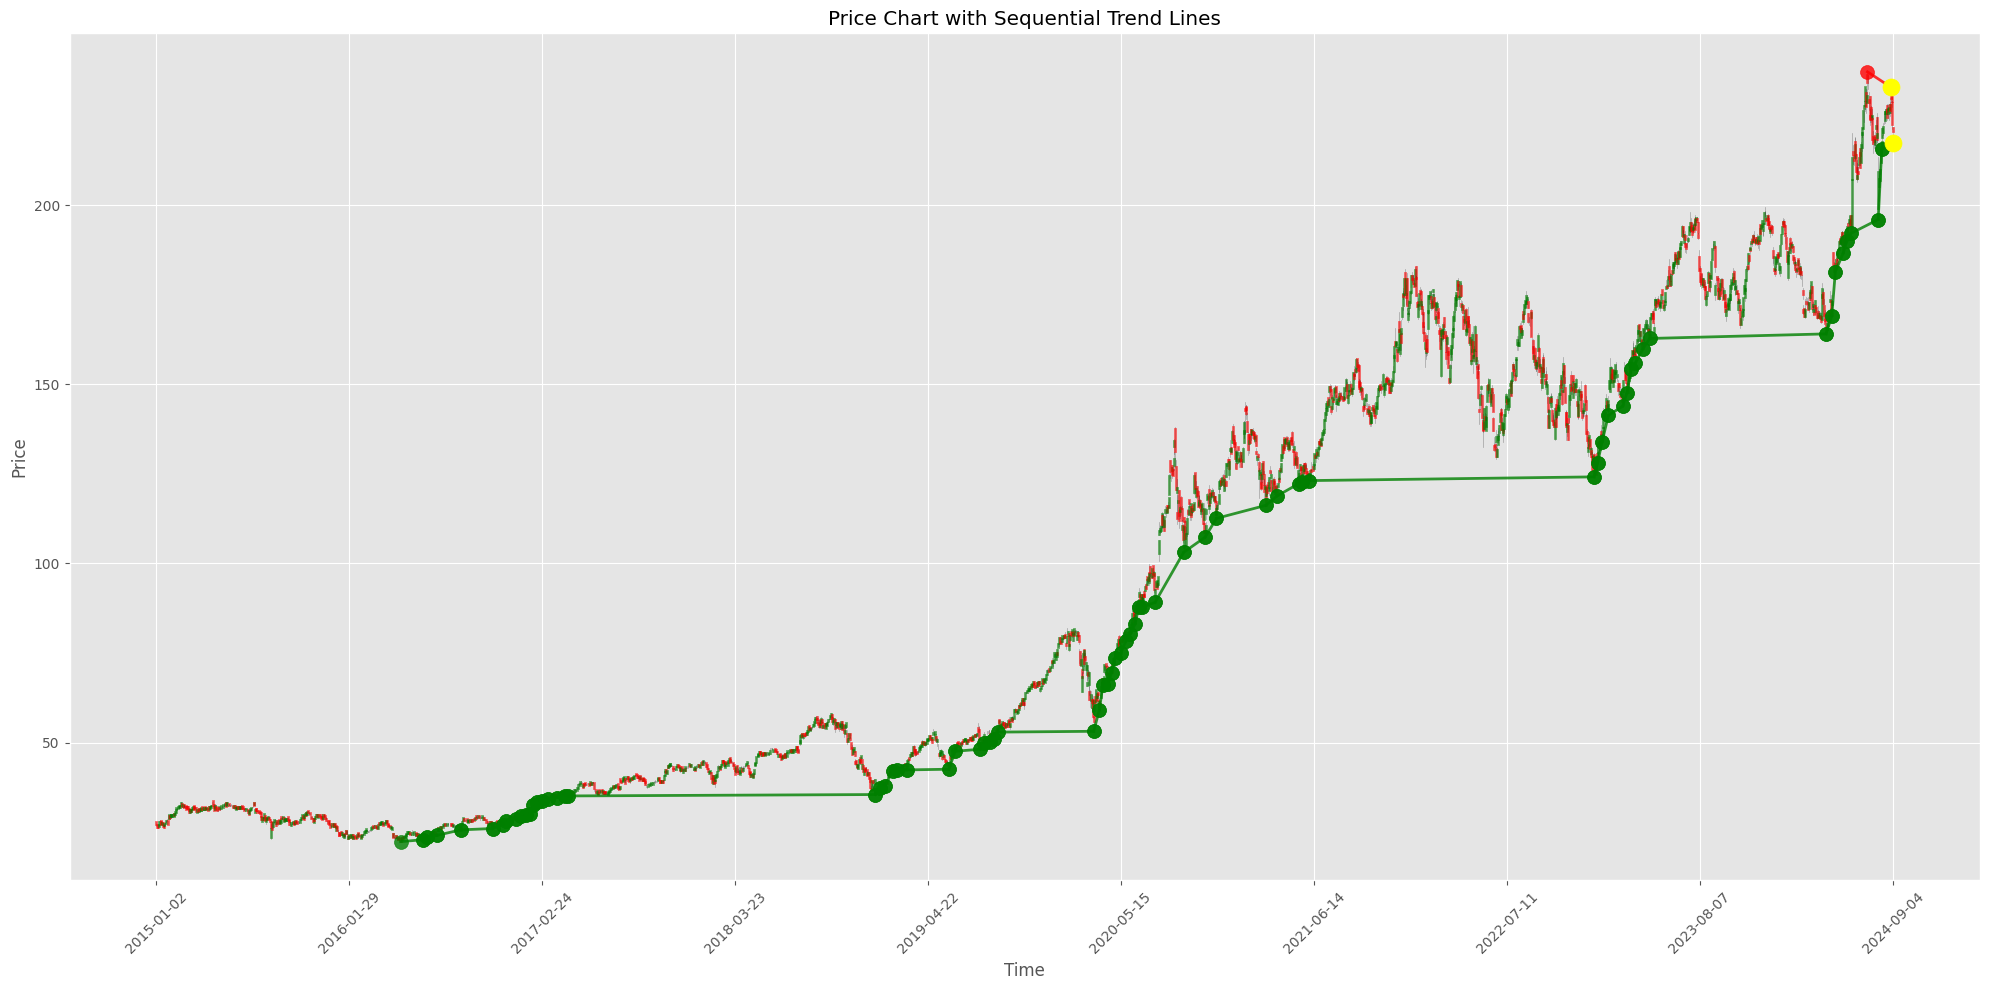

In [145]:
# Find sequential uptrend lines starting from the absolute lowest point
uptrend_data = find_sequential_trendlines(df, mode='lows', min_distance=5, max_lines=100)

# Find sequential downtrend lines starting from the absolute highest point
downtrend_data = find_sequential_trendlines(df, mode='highs', min_distance=5, max_lines=100)

print(f"Created {len(uptrend_data['trendlines'])} sequential uptrend lines")
print(f"Created {len(downtrend_data['trendlines'])} sequential downtrend lines")
print(f"Uptrend terminations: {len(uptrend_data['termination_points'])}")
print(f"Downtrend terminations: {len(downtrend_data['termination_points'])}")

# Plot the results
plot_sequential_trendlines(df, uptrend_data, downtrend_data)

# Interactive plot
plot_interactive_sequential_trendlines(df, uptrend_data, downtrend_data)

## 4. Visualizing Valid Trend Lines

# Functions to visualize the valid trend lines

Created 118 downtrend lines and 111 uptrend lines


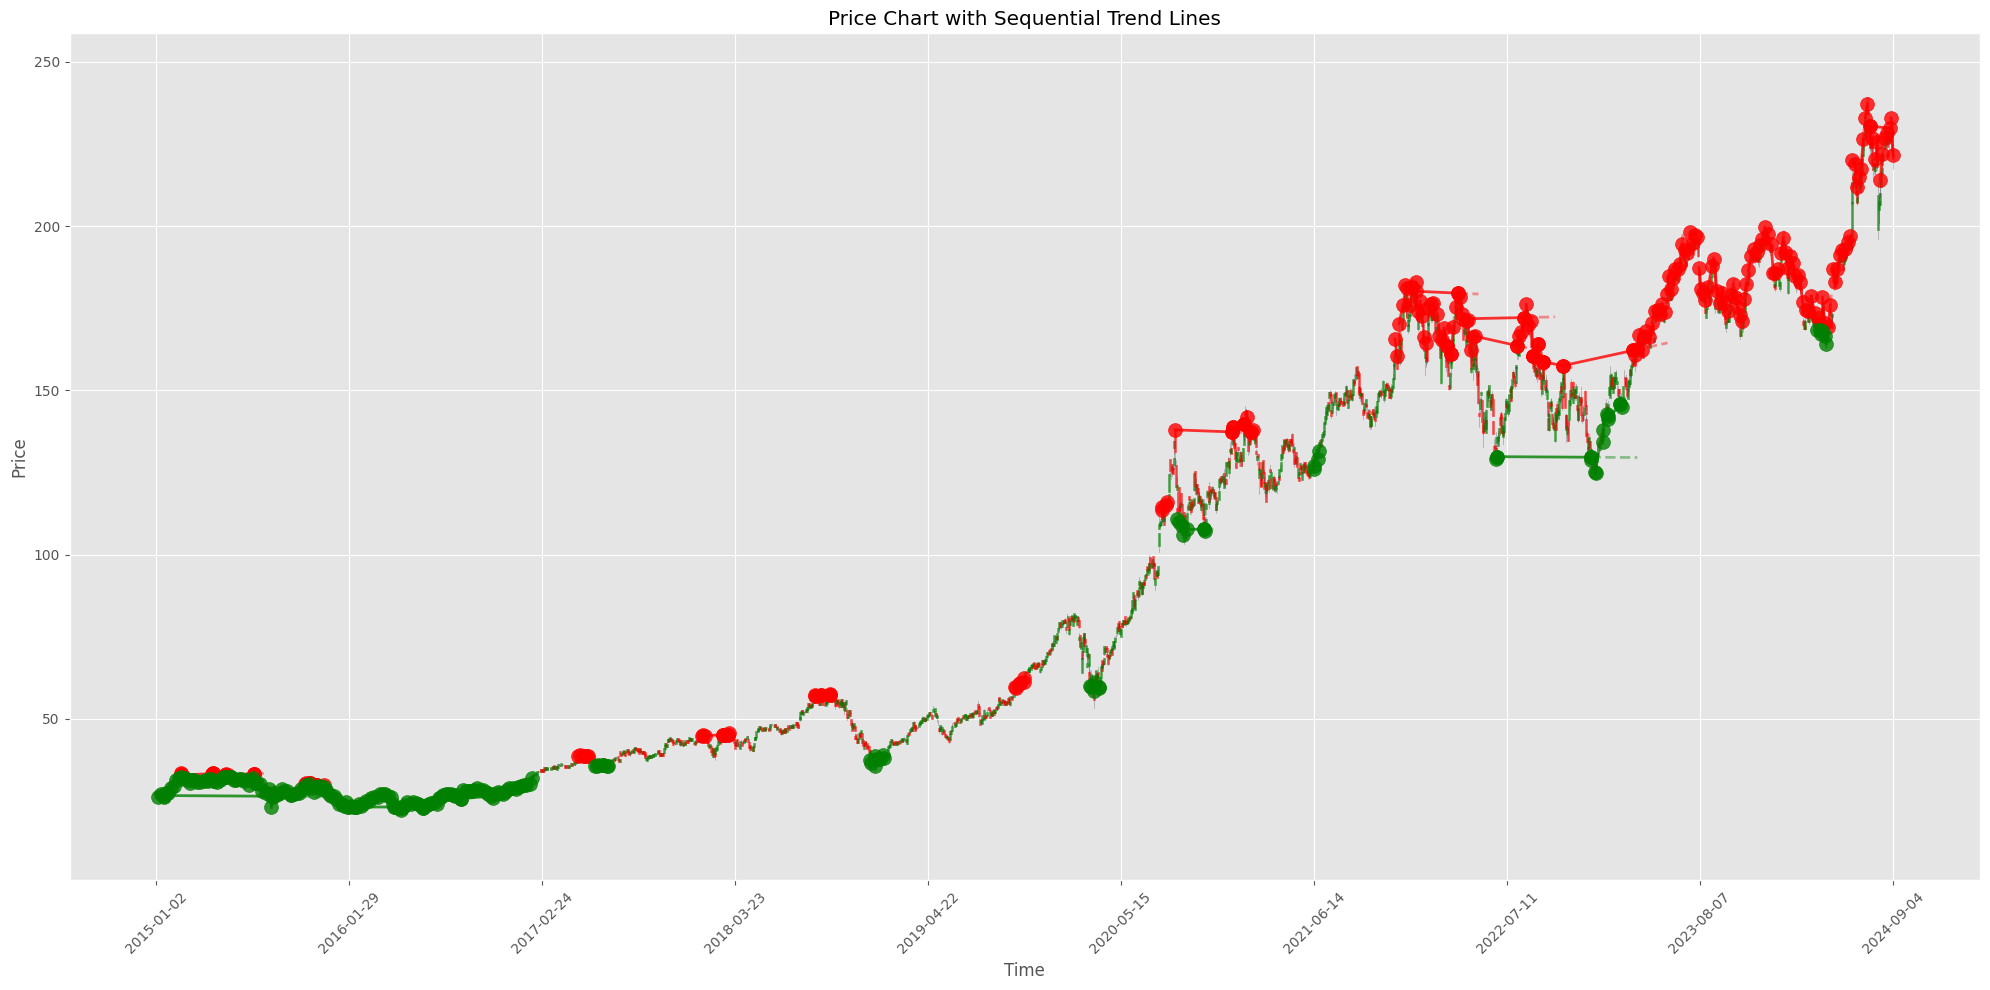

In [146]:
# Create trendlines with improved parameters for more comprehensive coverage
enhanced_trendlines = create_absolute_sequence_trendlines(
    df, 
    n_points=150,         # Significantly more points
    period_segments=12,   # More time segments
    min_distance=3        # Allow points to be closer
)

print(f"Created {len(enhanced_trendlines['downtrends'])} downtrend lines and {len(enhanced_trendlines['uptrends'])} uptrend lines")

# Plot with all trendlines visible
plot_with_trendlines(df, enhanced_trendlines, max_lines=500)  # Allow many more lines

# Interactive plot with all trendlines
plot_interactive_trendlines(df, enhanced_trendlines, max_lines=500)

In [147]:
def plot_with_trendlines(df, trendlines, start_idx=None, end_idx=None, max_lines=15):
    """
    Plot price chart with valid trendlines.
    
    Args:
        df: DataFrame with price data
        trendlines: Dictionary with uptrend and downtrend lines
        start_idx: Optional starting index for plot
        end_idx: Optional ending index for plot
        max_lines: Maximum number of trendlines to display
    """
    # Filter data for plotting if needed
    if start_idx is not None and end_idx is not None:
        plot_df = df.loc[start_idx:end_idx].copy()
    else:
        plot_df = df.copy()
        start_idx = plot_df.index.min()
        end_idx = plot_df.index.max()
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot candlesticks
    for idx, row in plot_df.iterrows():
        # Plot candle body
        color = 'green' if row['close'] >= row['open'] else 'red'
        ax.plot([idx, idx], [row['low'], row['high']], color='black', linewidth=0.5, alpha=0.3)
        ax.plot([idx, idx], [row['open'], row['close']], color=color, linewidth=2, alpha=0.6)
    
    # Calculate price range for setting y-axis limits later
    min_price = plot_df['low'].min()
    max_price = plot_df['high'].max()
    price_range = max_price - min_price
    
    # Plot downtrend lines (red)
    for i, trendline in enumerate(trendlines['downtrends'][:max_lines]):
        # Get original points
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Skip trendlines outside our viewing window
        if point1[0] > end_idx or point2[0] < start_idx:
            continue
        
        # Plot the original points
        ax.scatter(point1[0], point1[1], color='red', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='red', s=100, alpha=0.8, zorder=10)
        
        # Use line segments rather than extending too far
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='red', linewidth=2, alpha=0.8, linestyle='-')
        
        # Extend forward only to the chart edge or at most 50% further
        if point2[0] < end_idx:
            extension_length = min((end_idx - point2[0]), (point2[0] - point1[0]) * 0.5)
            if extension_length > 0:
                extension_end_idx = point2[0] + extension_length
                extension_price = line_equation(point1[0], point1[1], point2[0], point2[1], extension_end_idx)
                ax.plot([point2[0], extension_end_idx], [point2[1], extension_price], 
                        color='red', linewidth=2, alpha=0.4, linestyle='--')
    
    # Plot uptrend lines (green)
    for i, trendline in enumerate(trendlines['uptrends'][:max_lines]):
        # Get original points
        point1 = trendline['point1']
        point2 = trendline['point2']
        
        # Skip trendlines outside our viewing window
        if point1[0] > end_idx or point2[0] < start_idx:
            continue
        
        # Plot the original points
        ax.scatter(point1[0], point1[1], color='green', s=100, alpha=0.8, zorder=10)
        ax.scatter(point2[0], point2[1], color='green', s=100, alpha=0.8, zorder=10)
        
        # Use line segments rather than extending too far
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='green', linewidth=2, alpha=0.8, linestyle='-')
        
        # Extend forward only to the chart edge or at most 50% further
        if point2[0] < end_idx:
            extension_length = min((end_idx - point2[0]), (point2[0] - point1[0]) * 0.5)
            if extension_length > 0:
                extension_end_idx = point2[0] + extension_length
                extension_price = line_equation(point1[0], point1[1], point2[0], point2[1], extension_end_idx)
                ax.plot([point2[0], extension_end_idx], [point2[1], extension_price], 
                        color='green', linewidth=2, alpha=0.4, linestyle='--')
    
    # Set appropriate y-axis limits to avoid extreme projections
    y_min = min_price - price_range * 0.1
    y_max = max_price + price_range * 0.1
    ax.set_ylim(y_min, y_max)
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Price Chart with Valid Trend Lines')
    
    # Show x-axis as dates if date column is available
    if 'date' in plot_df.columns:
        date_indices = {idx: date.strftime('%Y-%m-%d') for idx, date in 
                       zip(plot_df.index, plot_df['date'])}
        tick_indices = np.linspace(plot_df.index.min(), plot_df.index.max(), 10, dtype=int)
        ax.set_xticks(tick_indices)
        ax.set_xticklabels([date_indices.get(idx, '') for idx in tick_indices], rotation=45)
    
    plt.tight_layout()
    plt.show()

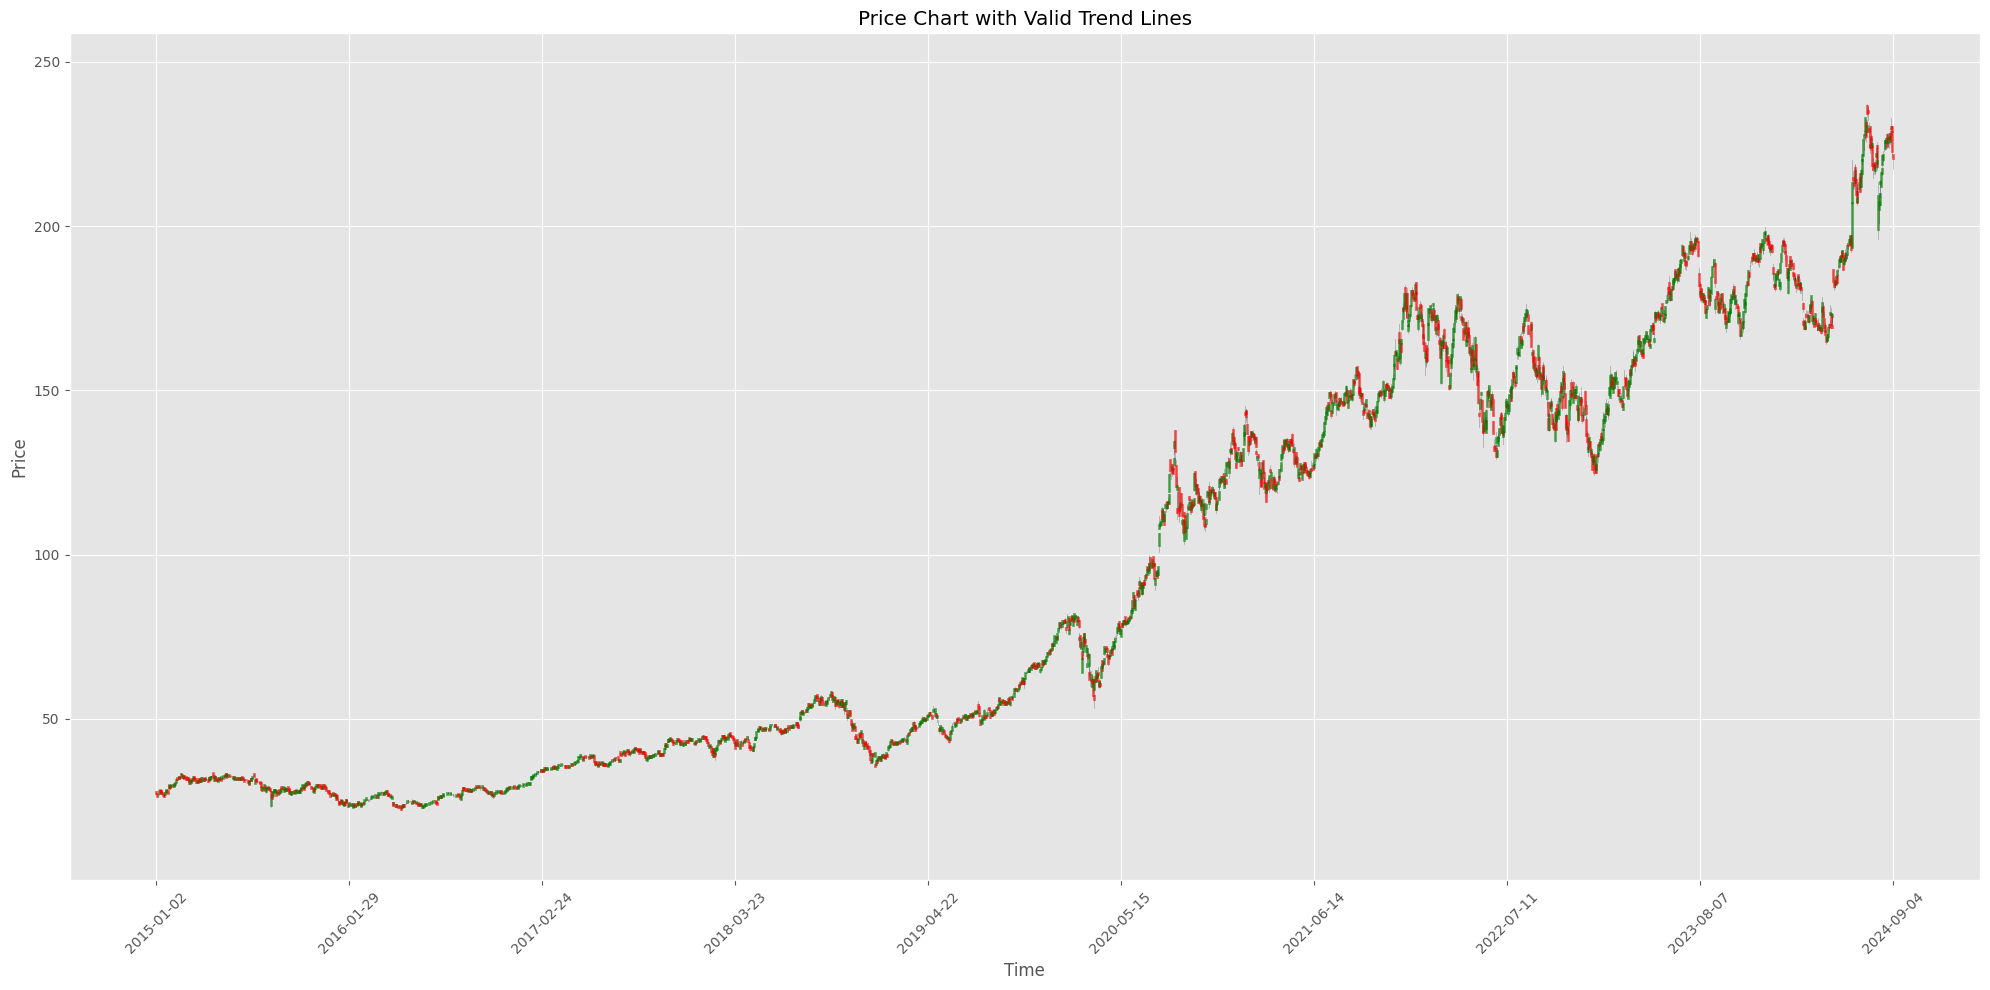

In [148]:
# Plot with trendlines for the entire dataset - showing sequential connections
plot_with_trendlines(df, ranked_trendlines, max_lines=20)

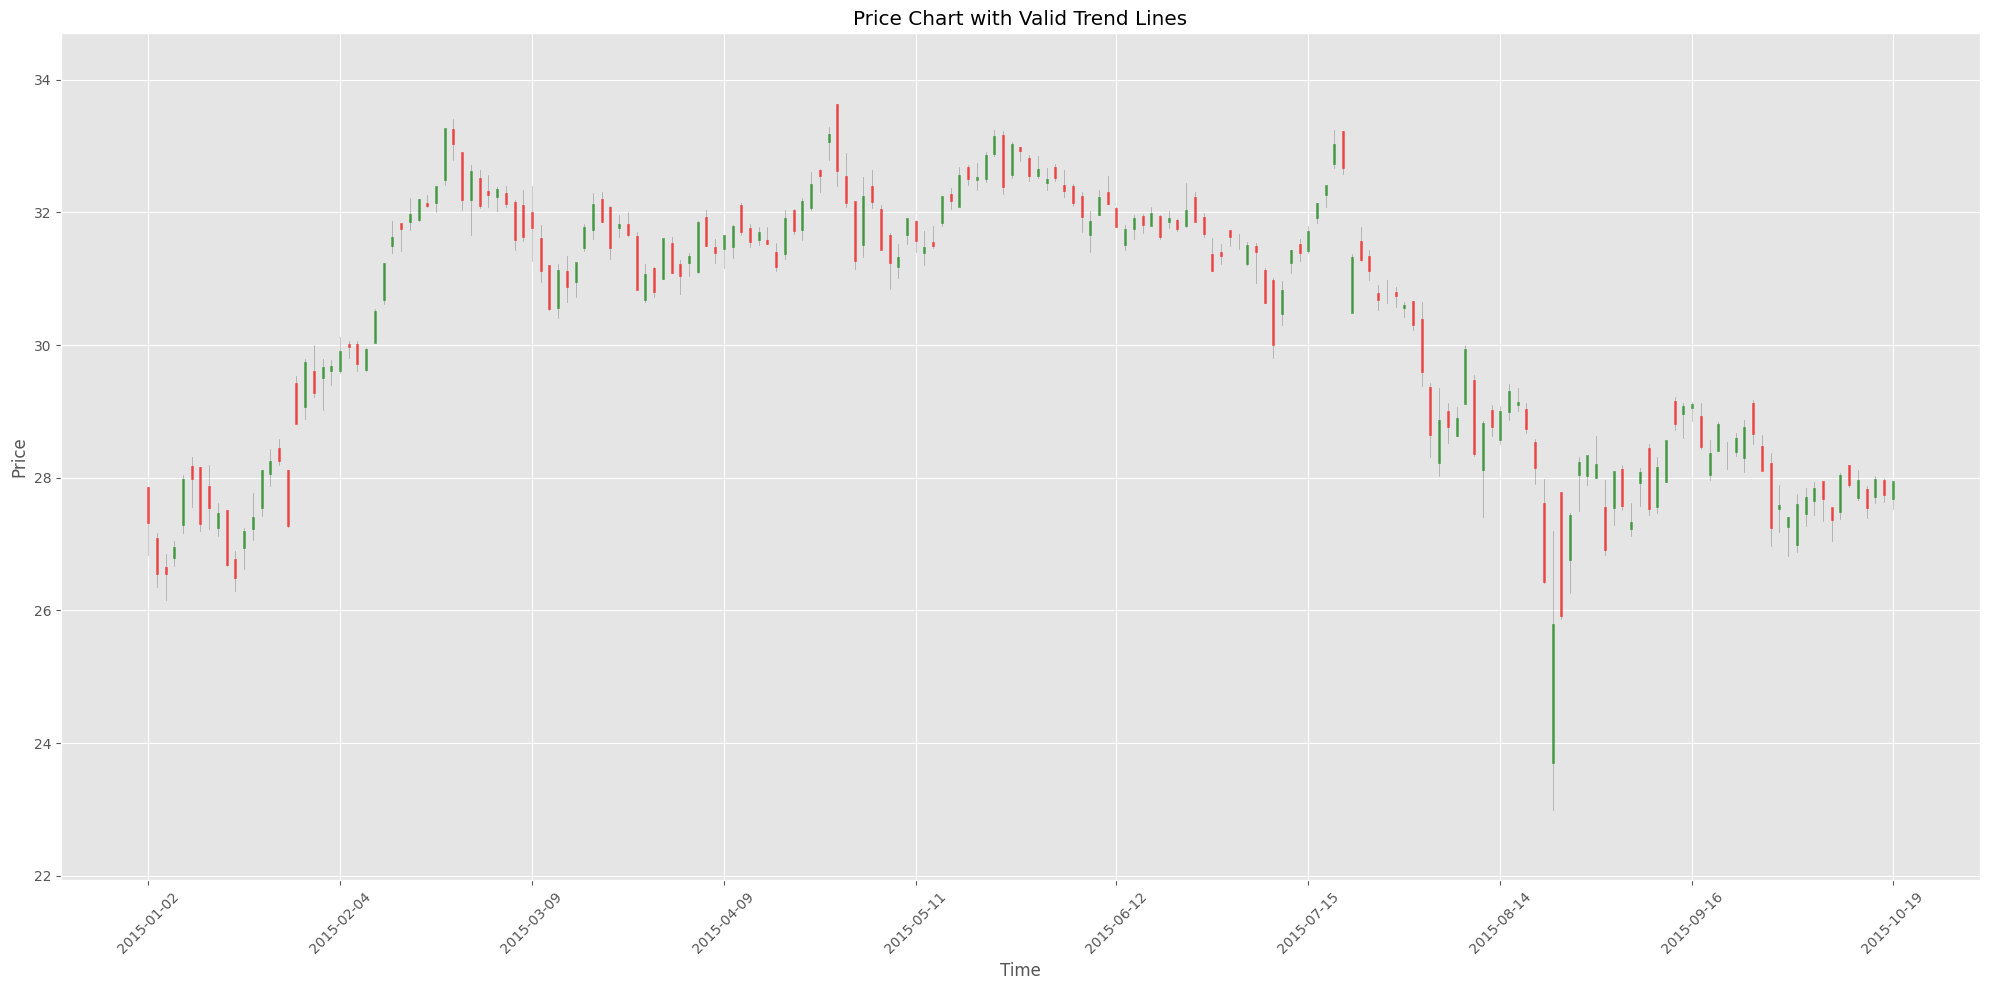

In [149]:
# Plot just part of the data for better visibility
if len(df) > 200:
    # Plot first 200 data points to see the early connections
    plot_with_trendlines(df, ranked_trendlines, start_idx=0, end_idx=200, max_lines=20)

## 5. Interactive Visualization with Plotly

In [150]:
def plot_interactive_trendlines(df, trendlines, max_lines=15):
    """
    Create an interactive plot with candlesticks and trendlines using Plotly.
    
    Args:
        df: DataFrame with price data
        trendlines: Dictionary with uptrend and downtrend lines
        max_lines: Maximum number of trendlines to display
    """
    fig = go.Figure()
    
    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df['date'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ))
    
    # Calculate price range for limiting extensions
    min_price = df['low'].min()
    max_price = df['high'].max()
    price_range = max_price - min_price
    
    # Add downtrend lines (red)
    for i, trendline in enumerate(trendlines['downtrends'][:max_lines]):
        # Get original points
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Only plot the actual line between the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='red', width=3),
            name=f'Downtrend {i+1}'
        ))
        
        # Add extension if not at the end of the data
        if idx2 < len(df) - 1:
            # Calculate modest extension (50% of original line length)
            time_delta = (date2 - date1) * 0.5
            date_end = date2 + time_delta
            
            # Find the closest future date in our dataset
            future_dates = df[df['date'] > date2]['date']
            if not future_dates.empty:
                closest_dates = future_dates[future_dates <= date_end]
                if not closest_dates.empty:
                    date_end = closest_dates.iloc[-1]
                    idx_end = df[df['date'] == date_end].index[0]
                    price_end = line_equation(idx1, price1, idx2, price2, idx_end)
                    
                    # Add dashed extension line
                    fig.add_trace(go.Scatter(
                        x=[date2, date_end],
                        y=[price2, price_end],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dash'),
                        name=f'Downtrend {i+1} extension',
                        showlegend=False
                    ))
        
        # Add points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='red', size=10),
            name=f'Downtrend {i+1} points',
            showlegend=False
        ))
    
    # Add uptrend lines (green)
    for i, trendline in enumerate(trendlines['uptrends'][:max_lines]):
        # Get original points
        idx1, price1 = trendline['point1']
        idx2, price2 = trendline['point2']
        date1 = df.iloc[idx1]['date']
        date2 = df.iloc[idx2]['date']
        
        # Only plot the actual line between the points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='lines',
            line=dict(color='green', width=3),
            name=f'Uptrend {i+1}'
        ))
        
        # Add extension if not at the end of the data
        if idx2 < len(df) - 1:
            # Calculate modest extension (50% of original line length)
            time_delta = (date2 - date1) * 0.5
            date_end = date2 + time_delta
            
            # Find the closest future date in our dataset
            future_dates = df[df['date'] > date2]['date']
            if not future_dates.empty:
                closest_dates = future_dates[future_dates <= date_end]
                if not closest_dates.empty:
                    date_end = closest_dates.iloc[-1]
                    idx_end = df[df['date'] == date_end].index[0]
                    price_end = line_equation(idx1, price1, idx2, price2, idx_end)
                    
                    # Add dashed extension line
                    fig.add_trace(go.Scatter(
                        x=[date2, date_end],
                        y=[price2, price_end],
                        mode='lines',
                        line=dict(color='green', width=2, dash='dash'),
                        name=f'Uptrend {i+1} extension',
                        showlegend=False
                    ))
        
        # Add points
        fig.add_trace(go.Scatter(
            x=[date1, date2],
            y=[price1, price2],
            mode='markers',
            marker=dict(color='green', size=10),
            name=f'Uptrend {i+1} points',
            showlegend=False
        ))
    
    # Set reasonable y-axis limits
    y_min = min_price - price_range * 0.1
    y_max = max_price + price_range * 0.1
    
    # Layout settings
    fig.update_layout(
        title='Price Chart with Valid Trend Lines',
        xaxis_title='Date',
        yaxis_title='Price',
        height=800,
        width=1200,
        xaxis_rangeslider_visible=True,
        template='plotly_white',
        yaxis=dict(range=[y_min, y_max]),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

In [151]:
# Create interactive plot showing sequential connections
plot_interactive_trendlines(df, ranked_trendlines, max_lines=20)

IndexError: single positional indexer is out-of-bounds